## Not neccessarily recommended to run the notebook as it will take most likely over an hour. All the outputs are there to be seen anyways.
### However if you want to run it, you will need at least the following packages:
pandas
nltk
numpy
sentistrength
matplotlib
empath
scipy
sklearn
### And you need to specify the path to SentiStrenghtCom.jar and sentistrength data folder in the first block below task 1. SentiStrength is a proprietary software that is available from the author for academic purposes. Because of the license, it is not supplied here.
Project 7: Sentiment Analysis of Twitter Dataset

This project aims to investigate the sentiment and test various architecture for argumenting the sentiment polarity in Twitter dataset. We shall consider a manually labelled dataset available at https://www.kaggle.com/yash612/stockmarket-sentiment-dataset. The dataset use manual labelling (+1 for positive sentiment tweet, -1 for negative positive, while neutral tweets are left unlabeled. Download the dataset in an easy searchable database. We would like to compare various sentiment analyzers and contrast evidence from individual raters. Use appropriate tokenizer, for instance, NLTK TweetTokenizer to process the tweet messages.

In [9]:
import pandas as pd
from collections import Counter
from nltk import TweetTokenizer
import numpy as np

# Read the csv
df = pd.read_csv('stock_data.csv')

# Basic info
print("Columns:\n", df.columns) # Text, Sentiment
print("Datatypes:\n", df.dtypes) # object, int64

# Distribution
counter = Counter()
for text, sent in df.values:
    counter[sent] += 1

pos_sent_count = counter[1]
neg_sent_count = counter[-1]
num_rows, _ = df.shape
print("Positive sentiment count: ", pos_sent_count)
print("Negative sentiment count: ", neg_sent_count)
print("Number of missing sentiment values: ", num_rows - pos_sent_count - neg_sent_count)

# Add tokenized tweets to the dataframe
tk = TweetTokenizer()
df["Tokenized"] = [tk.tokenize(text) for text in df["Text"]]

Columns:
 Index(['Text', 'Sentiment'], dtype='object')
Datatypes:
 Text         object
Sentiment     int64
dtype: object
Positive sentiment count:  3685
Negative sentiment count:  2106
Number of missing sentiment values:  0


In [2]:
# Maybe it is a good idea to create a database at this point
import sqlite3
conn = sqlite3.connect('data.db')

c = conn.cursor()
c.execute("PRAGMA foreign_keys = 1")
# Create a table for the original data and tokens
c.execute('''CREATE TABLE stock_data(
    id INTEGER NOT NULL PRIMARY KEY,
    text STRING NOT NULL,
    sentiment INTEGER NOT NULL)''')

c.execute('''CREATE TABLE tokens (
    id INTEGER NOT NULL,
    position INTEGER NOT NULL,
    token STRING NOT NULL,
    PRIMARY KEY (id, position)
    FOREIGN KEY (id)
        REFERENCES stock_data (id))
    ''')

conn.commit()
conn.close()

In [3]:
# Helper function for getting values from the db
def get_from_db(command):
    conn = sqlite3.connect('data.db')
    c = conn.cursor()
    c.execute(command)
    result = c.fetchall()
    conn.close()
    return result

In [4]:
# Add original data to the database

conn = sqlite3.connect('data.db')
c = conn.cursor()

for idx, row in df.iterrows():
    cmd = (f'''INSERT INTO stock_data (id, text, sentiment) 
        VALUES ({idx}, "{row["Text"]}", {row["Sentiment"]})''')
    try:
        c.execute(cmd)
    except:
        # duplicate single double quotes for sql
        sanitized_text = row["Text"].replace('"', '""')
        cmd = (f'''INSERT INTO stock_data (id, text, sentiment) 
        VALUES ({idx}, "{sanitized_text}", {row["Sentiment"]})''')
        c.execute(cmd)
        
    for tk_pos, token in enumerate(row["Tokenized"]):
        cmd = (f'''INSERT INTO tokens (id, position, token) 
            VALUES ({idx}, {tk_pos}, "{token}")''')
        try:
            c.execute(cmd)
        except:
            # duplicate single double quotes for sql
            sanitized_token = token.replace('"', '""')
            cmd = (f'''INSERT INTO tokens (id, position, token) 
            VALUES ({idx}, {tk_pos}, "{sanitized_token}")''')
            c.execute(cmd)
conn.commit()

# Sanity check
c.execute('SELECT * FROM stock_data WHERE id = 1')
print(c.fetchall())
c.execute('SELECT * FROM tokens WHERE id = 1')
print(c.fetchall())
conn.close()

[(1, 'user: AAP MOVIE. 55% return for the FEA/GEED indicator just 15 trades for the year.  AWESOME.  ', 1)]
[(1, 0, 'user'), (1, 1, ':'), (1, 2, 'AAP'), (1, 3, 'MOVIE'), (1, 4, '.'), (1, 5, 55), (1, 6, '%'), (1, 7, 'return'), (1, 8, 'for'), (1, 9, 'the'), (1, 10, 'FEA'), (1, 11, '/'), (1, 12, 'GEED'), (1, 13, 'indicator'), (1, 14, 'just'), (1, 15, 15), (1, 16, 'trades'), (1, 17, 'for'), (1, 18, 'the'), (1, 19, 'year'), (1, 20, '.'), (1, 21, 'AWESOME'), (1, 22, '.')]


### 1. 
Use the SentiStrength from http://sentistrength.wlv.ac.uk/ to determine the positive, negative and overall (sum of positive and negative) sentiment score for each tweet message. Provide a database D, which contains these information for each tweet. 

In [5]:
# Setup SentiStrength
from sentistrength import PySentiStr
senti = PySentiStr()
senti_path = '<sentistrength_path>'
senti.setSentiStrengthPath('{}/SentiStrengthCom.jar'.format(senti_path)) 
senti.setSentiStrengthLanguageFolderPath('{}/SentiStrengthData/'.format(senti_path))


In [6]:
# Calculate positive, negative and overall values for 
# each tokenized tweet using SentiStrength
df["SSPos"] = np.nan
df["SSNeg"] = np.nan
df["SSOvrl"] = np.nan

for idx, tk_tweet in enumerate(df['Tokenized']):
    sentiment = np.array(senti.getSentiment(tk_tweet, score='scale'))
    positive = sum(sentiment > 0)
    negative = sum(sentiment < 0)
    overall = sum(sentiment)
    df.loc[idx, "SSPos"] = positive
    df.loc[idx, "SSNeg"] = negative
    df.loc[idx, "SSOvrl"] = overall


In [7]:
# Create new table for SentiStrength values
conn = sqlite3.connect('data.db')
c = conn.cursor()
c.execute('''CREATE TABLE sentistrength (
    id INTEGER NOT NULL,
    positive INTEGER NOT NULL,
    negative INTEGER NOT NULL,
    overall INTEGER NOT NULL,
    PRIMARY KEY (id)
    FOREIGN KEY (id)
        REFERENCES stock_data (id))
    ''')
conn.commit()
conn.close()


In [8]:
# Insert SentiStrength values into the database
conn = sqlite3.connect('data.db')
c = conn.cursor()

for idx, row in df.iterrows():
    cmd = f'''INSERT INTO sentistrength (id, positive, negative, overall) 
        VALUES ({idx}, {row["SSPos"]}, {row["SSNeg"]}, {row["SSOvrl"]})'''
    c.execute(cmd)
conn.commit()
conn.close()


In [9]:
# Sanity check part 2
conn = sqlite3.connect('data.db')
c = conn.cursor()

cmd = "SELECT * FROM stock_data WHERE id = 500"
c.execute(cmd)
print(c.fetchall())

cmd = "SELECT * FROM sentistrength WHERE id = 500"
c.execute(cmd)
print(c.fetchall())

conn.close()

df.iloc[500]


[(500, 'FCE triggered Tues gapped Wed so today IMO do not have to think - you just take profits   ', 1)]
[(500, 1, 0, 1)]


Text         FCE triggered Tues gapped Wed so today IMO do ...
Sentiment                                                    1
Tokenized    [FCE, triggered, Tues, gapped, Wed, so, today,...
SSPos                                                        1
SSNeg                                                        0
SSOvrl                                                       1
Name: 500, dtype: object

## 2.
Repeat 1) using another sentiment analyzer of your choice (i.e., Textblob sentiment, NLTK Vader sentiment), and save the result in the same database D (you may only provide the overall sentiment score if the sentiment software does not provide separate value for positive and negative scores). 

In [10]:
# Initialize Vader analyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import download as nltk_download
nltk_download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/arttu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [11]:
# Vader is used with complete texts instead of tokens so we'll use the original texts
# It returns proportional sentiments e.g. 0.40 pos, 0.30 neut, 0.3 neg so we need to
# transform these values to represent the number of words that are positive to get
# the same format as with SentiStrength

df["VaderPos"] = np.nan
df["VaderNeg"] = np.nan
df["VaderOvrl"] = np.nan

for idx, tweet in enumerate(df['Text']):
    sentiment = analyzer.polarity_scores(tweet)
    num_tokens = len(df.loc[idx, "Tokenized"])

    # Although this will sometimes* result in too few or many words due to rounding error
    # * in 3.5% in this case, it does not really matter as we are mostly concerned about
    # the binary 1/-1 sentiment
    positive = round(num_tokens * sentiment["pos"])
    negative = -round(num_tokens * sentiment["neg"])
    overall = positive + negative
    df.loc[idx, "VaderPos"] = positive
    df.loc[idx, "VaderNeg"] = negative
    df.loc[idx, "VaderOvrl"] = overall
    

In [12]:
# Create table for vader sentiment scores
conn = sqlite3.connect('data.db')
c = conn.cursor()
c.execute('''CREATE TABLE vader (
    id INTEGER NOT NULL,
    positive INTEGER NOT NULL,
    negative INTEGER NOT NULL,
    overall INTEGER NOT NULL,
    PRIMARY KEY (id)
    FOREIGN KEY (id)
        REFERENCES stock_data (id))
    ''')
conn.commit()
conn.close()

In [13]:
# Add vader sentiment scores to the db
conn = sqlite3.connect('data.db')
c = conn.cursor()

for idx, row in df.iterrows():
    cmd = f'''INSERT INTO vader (id, positive, negative, overall) 
        VALUES ({idx}, {row["VaderPos"]}, {row["VaderNeg"]}, {row["VaderOvrl"]})'''
    c.execute(cmd)
conn.commit()
conn.close()


## 3.
Draw on the same plot, the sentiment analyzer 1 (SentiStrength), sentiment analyzer 2 (Vader) and the user’s labelled value (You should complete the missing labelling of the neutral tweets by putting zero value on all unlabeled tweets).  Determine for each sentiment analyzer, the correlation between the vector carrying the overall sentiment score and that of the overall rating (Use the formula of Pearson correlation coefficient to calculate the correlation, which implemented in several Python libraries). 

(-1.5, 1.5)

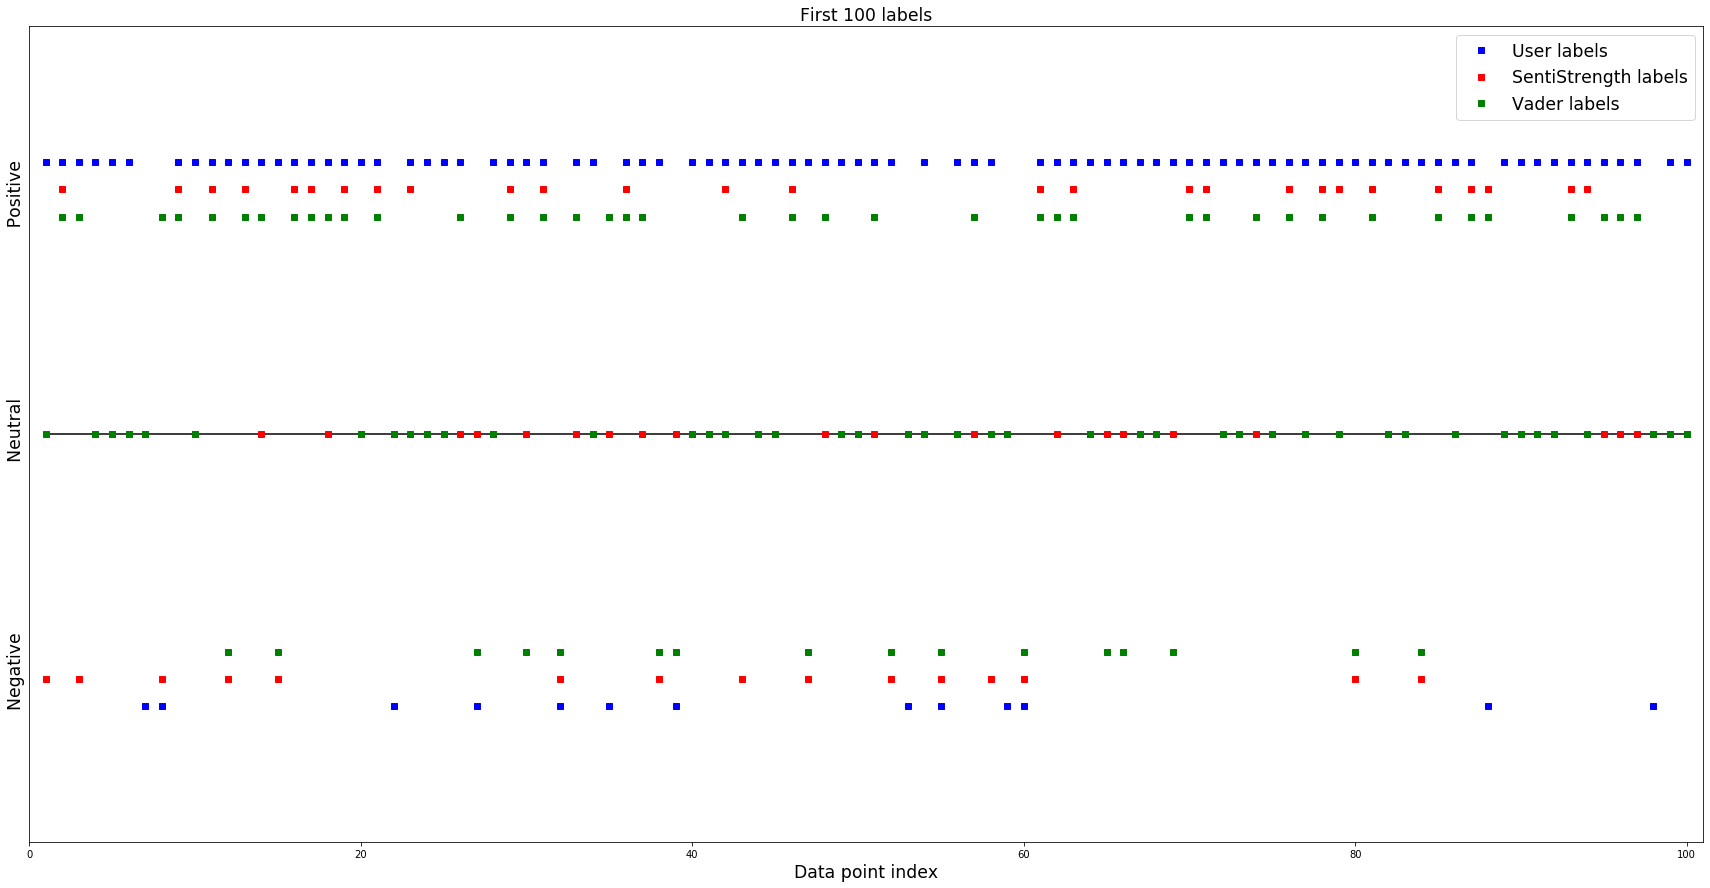

In [14]:
# Plot user's labeled values, sentistrength and vader values onto the same plot
import matplotlib.pyplot as plt



conn = sqlite3.connect('data.db')
c = conn.cursor()

c.execute('SELECT id, overall FROM sentistrength')
db_senti_labels = c.fetchall()
c.execute('SELECT id, overall FROM vader')
db_vader_labels = c.fetchall()
conn.close()

# senti_labels and vader_labels for visualization
# add binary 1/-1 values to the df for correlation calculation
senti_labels = []
senti_labels2 = []
df["SSBin"] = np.nan
df["SSPosNeuNeg"] = np.nan
for idx, sent_value in db_senti_labels:
    if sent_value > 0:
        df.loc[idx, "SSPosNeuNeg"] = 1
        df.loc[idx, "SSBin"] = 1
        senti_labels.append(0.9)
    elif sent_value == 0:
        df.loc[idx, "SSPosNeuNeg"] = 0
        df.loc[idx, "SSBin"] = 1
        senti_labels.append(0)
    else:
        df.loc[idx, "SSPosNeuNeg"] = -1
        df.loc[idx, "SSBin"] = 0
        senti_labels.append(-0.9)
        


vader_labels = []
df["VaderBin"] = np.nan
df["VaderPosNeuNeg"] = np.nan
for idx, sent_value in db_vader_labels:
    if sent_value > 0:
        df.loc[idx, "VaderPosNeuNeg"] = 1
        df.loc[idx, "VaderBin"] = 1
        vader_labels.append(0.8)
    elif sent_value == 0:
        df.loc[idx, "VaderPosNeuNeg"] = 0
        df.loc[idx, "VaderBin"] = 1
        vader_labels.append(0)
    else:
        vader_labels.append(-0.8)
        df.loc[idx, "VaderPosNeuNeg"] = -1
        df.loc[idx, "VaderBin"] = 0

# vectors for each set of values normalized to 1/-1
user_labels = [row["Sentiment"] for idx, row in df.iterrows()]
x_axis = np.arange(1, len(user_labels) + 1, 1)

# Plot only the first 100 to get somewhat readable plot
# The predicted values are set to +-0.9 and +-0.8 for visualization purposes
fig, ax = plt.subplots(figsize=(30, 15))
num_samples = 100

ax.plot(x_axis[:num_samples], [0]*num_samples, color="black")
ax.plot(x_axis[:num_samples], user_labels[:num_samples], 'bs', label="User labels")
ax.plot(x_axis[:num_samples], senti_labels[:num_samples], 'rs', label="SentiStrength labels")
ax.plot(x_axis[:num_samples], vader_labels[:num_samples], 'gs', label="Vader labels")

ax.legend(loc="best", fontsize="xx-large")

ax.set_title(f"First {num_samples} labels", fontsize="xx-large")
y_label = f"Negative {30* ' ' + 'Neutral' + ' ' * 30} Positive"
ax.set_xlabel("Data point index", fontsize="xx-large")

ax.get_yaxis().set_ticks([])
ax.set_ylabel(y_label, fontsize="xx-large")
ax.set_xlim([0,num_samples+1])
ax.set_ylim([-1.5,1.5])

In [15]:
# Calculate the Pearson correlation (SS and Vader values in 1, -1, neutral is considered positive)
df[["Sentiment", "SSBin", "VaderBin"]].corr(method="pearson")

,Sentiment,SSBin,VaderBin
Sentiment,1.000000,0.244187,0.214663
SSBin,0.244187,1.000000,0.530712
VaderBin,0.214663,0.530712,1.000000


In [16]:
# SS and Vader values are in 1, 0, -1
df[["Sentiment", "SSPosNeuNeg", "VaderPosNeuNeg"]].corr(method="pearson")

,Sentiment,SSPosNeuNeg,VaderPosNeuNeg
Sentiment,1.000000,0.231426,0.22517
SSPosNeuNeg,0.231426,1.000000,0.59243
VaderPosNeuNeg,0.225170,0.592430,1.00000


In [17]:
# Only rows where both SS and Vader have given a nonzero value 
df.loc[df['SSPosNeuNeg'].isin([1, -1]) & (df['VaderPosNeuNeg'].isin([1, -1]))][["Sentiment", "SSPosNeuNeg", "VaderPosNeuNeg"]].corr(method="pearson")


,Sentiment,SSPosNeuNeg,VaderPosNeuNeg
Sentiment,1.000000,0.351700,0.355529
SSPosNeuNeg,0.351700,1.000000,0.780806
VaderPosNeuNeg,0.355529,0.780806,1.000000


In [18]:
# Rows where SS has given a nonzero value 
df.loc[df['SSPosNeuNeg'].isin([1, -1])][["Sentiment", "SSBin"]].corr(method="pearson")

,Sentiment,SSBin
Sentiment,1.000000,0.340366
SSBin,0.340366,1.000000


In [19]:
# Rows where Vader has given a nonzero value 
df.loc[df['VaderPosNeuNeg'].isin([1, -1])][["Sentiment", "VaderBin"]].corr(method="pearson")

,Sentiment,VaderBin
Sentiment,1.0000,0.3045
VaderBin,0.3045,1.0000


In [20]:
df.loc[(df['SSPosNeuNeg'] == df['VaderPosNeuNeg']) & (df['SSPosNeuNeg'].isin([1, -1]))][["Sentiment", "SSPosNeuNeg", "VaderPosNeuNeg"]].corr(method="pearson")

,Sentiment,SSPosNeuNeg,VaderPosNeuNeg
Sentiment,1.000000,0.395939,0.395939
SSPosNeuNeg,0.395939,1.000000,1.000000
VaderPosNeuNeg,0.395939,1.000000,1.000000


In [21]:
print("Number of non-neutral tweets by Vader:", len(df.loc[df['VaderPosNeuNeg'] != 0]))
print("Number of non-neutral tweets by SS:", len(df.loc[df['SSPosNeuNeg'] != 0]))
print("Number of non-neutral tweets by both Vader and SS:", len(df.loc[(df['SSPosNeuNeg'] != 0) & (df['VaderPosNeuNeg'] != 0)]))
print("Number of non-neutral tweets where Vader and SS agree on the label:",len(df.loc[(df['SSPosNeuNeg'] == df['VaderPosNeuNeg']) & (df['SSPosNeuNeg'].isin([1, -1]))]))

Number of non-neutral tweets by Vader: 3316
Number of non-neutral tweets by SS: 2582
Number of non-neutral tweets by both Vader and SS: 2189
Number of non-neutral tweets where Vader and SS agree on the label: 1949


Findings:

-Vader classifies more tweets with a positive or negative sentiment value than SentiStrength. However, sentiment provided by SentiStrength has higher correlation with the user assigned labels than Vader sentiment does.

-The correlation of these labels is higher, when only the rows are selected that were classified by Vader and Sentistrength as either postive or negative (sentiment provided by these methods can be different on the same tweet).

-The correlation is at its highest when Vader and SentiStrength also agree on the label.

-The correlation between sentiment provided by Vader and SentiStrength is much higher than the correlation between either of these methods and users labels.  

-When neutral category is considered as positive, the correlation between these methods and user labels is at its lowest. 

## 4.
Consider categories generated by Empath Client https://github.com/Ejhfast/empath-client. Apply Empath Client to each tweet message and record the categories for which the associated score is non-zero. Report these categories in the database D.  

In [22]:
# Create tables for empath categories
conn = sqlite3.connect('data.db')
c = conn.cursor()
c.execute('''CREATE TABLE empath_categories (
    category_id INTEGER NOT NULL,
    category_name STRING NOT NULL,
    PRIMARY KEY (category_id))
    ''')
conn.commit()
c.execute('''CREATE TABLE empath (
    id INTEGER NOT NULL,
    category_id INTEGER NOT NULL,
    PRIMARY KEY (id, category_id)
    FOREIGN KEY (id)
        REFERENCES stock_data (id)
    FOREIGN KEY (category_id)
        REFERENCES empath_categories (category_id))
    ''')
conn.commit()
conn.close()

In [23]:
# Fill empath categories table
from empath import Empath
lexicon = Empath()

conn = sqlite3.connect('data.db')
c = conn.cursor()

for idx, cat in enumerate(lexicon.cats):
    c.execute(f'''INSERT INTO empath_categories (category_id, category_name)
    VALUES ({idx}, "{cat}")''')
    
conn.commit()
conn.close()

In [24]:
def omit_by(dct, predicate=lambda x: x!=0):
    return [k for k, v in dct.items() if predicate(v)]

db_texts = get_from_db('''SELECT id, text FROM stock_data''')

conn = sqlite3.connect('data.db')
c = conn.cursor()
for _id, text in db_texts:
    result = lexicon.analyze(text, normalize=True)
    if not result:
        continue
    nonzero_keys = omit_by(result)
    for cat in nonzero_keys:
        # get category id
        c.execute(f'''SELECT category_id from empath_categories
        WHERE category_name = "{cat}"''')
        cat_id = c.fetchone()[0]
        
        c.execute(f'''INSERT INTO empath (id, category_id)
        VALUES ({_id}, {cat_id})''')
conn.commit()
conn.close()

In [25]:
# Sanity check part 3
conn = sqlite3.connect('data.db')
c = conn.cursor()
c.execute('''SELECT empath.id, empath_categories.category_name 
    FROM empath
    INNER JOIN empath_categories
    ON empath.category_id = empath_categories.category_id''')
result = c.fetchall()
for r in result:
    print(r)
conn.close()

(0, 'money')
(0, 'business')
(0, 'gain')
(0, 'valuable')
(0, 'economics')
(0, 'negotiate')
(1, 'giving')
(2, 'attractive')
(2, 'nervousness')
(2, 'fear')
(2, 'hipster')
(2, 'violence')
(2, 'appearance')
(2, 'pain')
(2, 'timidity')
(2, 'negative_emotion')
(7, 'family')
(8, 'school')
(8, 'social_media')
(8, 'internet')
(8, 'noise')
(8, 'hearing')
(8, 'music')
(8, 'listen')
(8, 'sound')
(9, 'play')
(10, 'weapon')
(11, 'celebration')
(11, 'shopping')
(11, 'economics')
(13, 'wedding')
(13, 'internet')
(13, 'communication')
(13, 'trust')
(13, 'speaking')
(13, 'giving')
(14, 'noise')
(14, 'hearing')
(14, 'fight')
(14, 'music')
(14, 'war')
(14, 'listen')
(14, 'sound')
(14, 'strength')
(16, 'social_media')
(16, 'internet')
(16, 'injury')
(16, 'breaking')
(16, 'negative_emotion')
(16, 'alcohol')
(16, 'weapon')
(17, 'attractive')
(17, 'hipster')
(17, 'independence')
(17, 'movement')
(17, 'writing')
(18, 'money')
(18, 'real_estate')
(18, 'communication')
(18, 'toy')
(18, 'shopping')
(18, 'achievem

(1315, 'royalty')
(1315, 'wealthy')
(1315, 'journalism')
(1315, 'banking')
(1315, 'valuable')
(1315, 'economics')
(1316, 'sleep')
(1316, 'anticipation')
(1316, 'morning')
(1316, 'night')
(1316, 'noise')
(1316, 'hearing')
(1316, 'weather')
(1316, 'music')
(1316, 'listen')
(1316, 'sound')
(1316, 'shape_and_size')
(1316, 'alcohol')
(1316, 'weapon')
(1317, 'communication')
(1318, 'money')
(1318, 'business')
(1318, 'fabric')
(1318, 'gain')
(1318, 'valuable')
(1318, 'warmth')
(1318, 'economics')
(1318, 'negotiate')
(1321, 'attractive')
(1321, 'hipster')
(1321, 'communication')
(1321, 'achievement')
(1321, 'positive_emotion')
(1322, 'social_media')
(1322, 'internet')
(1323, 'money')
(1323, 'wealthy')
(1323, 'banking')
(1323, 'business')
(1323, 'shopping')
(1323, 'valuable')
(1323, 'economics')
(1323, 'strength')
(1323, 'negotiate')
(1323, 'negative_emotion')
(1323, 'payment')
(1323, 'giving')
(1324, 'money')
(1324, 'wealthy')
(1324, 'morning')
(1324, 'shopping')
(1324, 'valuable')
(1324, 'eco

(2637, 'love')
(2637, 'shopping')
(2637, 'shame')
(2637, 'economics')
(2637, 'pain')
(2637, 'contentment')
(2638, 'wedding')
(2638, 'cold')
(2638, 'cheerfulness')
(2638, 'swearing_terms')
(2638, 'optimism')
(2638, 'childish')
(2638, 'body')
(2638, 'celebration')
(2638, 'speaking')
(2638, 'party')
(2638, 'positive_emotion')
(2641, 'weakness')
(2641, 'suffering')
(2641, 'death')
(2641, 'violence')
(2641, 'sympathy')
(2641, 'injury')
(2641, 'sadness')
(2641, 'torment')
(2641, 'breaking')
(2641, 'pain')
(2642, 'hearing')
(2642, 'shape_and_size')
(2644, 'money')
(2644, 'wealthy')
(2644, 'shopping')
(2644, 'valuable')
(2644, 'economics')
(2644, 'payment')
(2648, 'weakness')
(2648, 'suffering')
(2648, 'death')
(2648, 'violence')
(2648, 'sympathy')
(2648, 'injury')
(2648, 'sadness')
(2648, 'torment')
(2648, 'breaking')
(2648, 'pain')
(2649, 'gain')
(2649, 'appearance')
(2649, 'technology')
(2649, 'competing')
(2650, 'gain')
(2650, 'appearance')
(2650, 'technology')
(2650, 'competing')
(2651, '

(3640, 'air_travel')
(3640, 'vehicle')
(3640, 'traveling')
(3640, 'car')
(3641, 'help')
(3641, 'writing')
(3642, 'money')
(3642, 'wealthy')
(3642, 'banking')
(3642, 'violence')
(3642, 'music')
(3642, 'listen')
(3642, 'gain')
(3642, 'economics')
(3642, 'poor')
(3642, 'negative_emotion')
(3643, 'noise')
(3643, 'hearing')
(3643, 'music')
(3643, 'listen')
(3643, 'sound')
(3647, 'domestic_work')
(3647, 'occupation')
(3647, 'blue_collar_job')
(3647, 'childish')
(3647, 'shopping')
(3647, 'work')
(3647, 'economics')
(3647, 'shape_and_size')
(3647, 'white_collar_job')
(3647, 'poor')
(3647, 'children')
(3647, 'giving')
(3648, 'politeness')
(3648, 'friends')
(3649, 'kill')
(3649, 'monster')
(3651, 'office')
(3651, 'computer')
(3651, 'technology')
(3652, 'attractive')
(3652, 'hipster')
(3652, 'appearance')
(3652, 'youth')
(3652, 'feminine')
(3653, 'help')
(3657, 'movement')
(3657, 'order')
(3658, 'movement')
(3658, 'hiking')
(3658, 'smell')
(3659, 'speaking')
(3659, 'gain')
(3663, 'money')
(3663, 

(4816, 'shopping')
(4816, 'valuable')
(4816, 'sadness')
(4816, 'traveling')
(4816, 'economics')
(4816, 'disappointment')
(4816, 'negotiate')
(4818, 'social_media')
(4818, 'play')
(4818, 'shape_and_size')
(4819, 'fire')
(4821, 'movement')
(4823, 'writing')
(4824, 'noise')
(4824, 'hearing')
(4824, 'music')
(4824, 'listen')
(4824, 'sound')
(4824, 'appearance')
(4825, 'speaking')
(4825, 'appearance')
(4825, 'timidity')
(4826, 'appearance')
(4827, 'attractive')
(4827, 'hipster')
(4827, 'movement')
(4827, 'traveling')
(4831, 'politeness')
(4831, 'friends')
(4833, 'money')
(4833, 'banking')
(4833, 'appearance')
(4833, 'fashion')
(4833, 'payment')
(4833, 'feminine')
(4835, 'money')
(4835, 'wealthy')
(4835, 'exercise')
(4835, 'optimism')
(4835, 'real_estate')
(4835, 'love')
(4835, 'hiking')
(4835, 'shopping')
(4835, 'valuable')
(4835, 'affection')
(4835, 'economics')
(4835, 'friends')
(4835, 'payment')
(4835, 'positive_emotion')
(4836, 'reading')
(4836, 'writing')
(4837, 'shopping')
(4837, 'inj

## 5.
Separate the set of review found to be assigned to positive sentiment in both Sentiment analyzer 1 and 2 and the set of reviews related to negative sentiment. Construct histogram of Empath categories showing the frequency of each category for positive sentiment dataset and that pertaining to negative sentiment.  Comment on the use of Empath categories to track the sentiment polarity.  

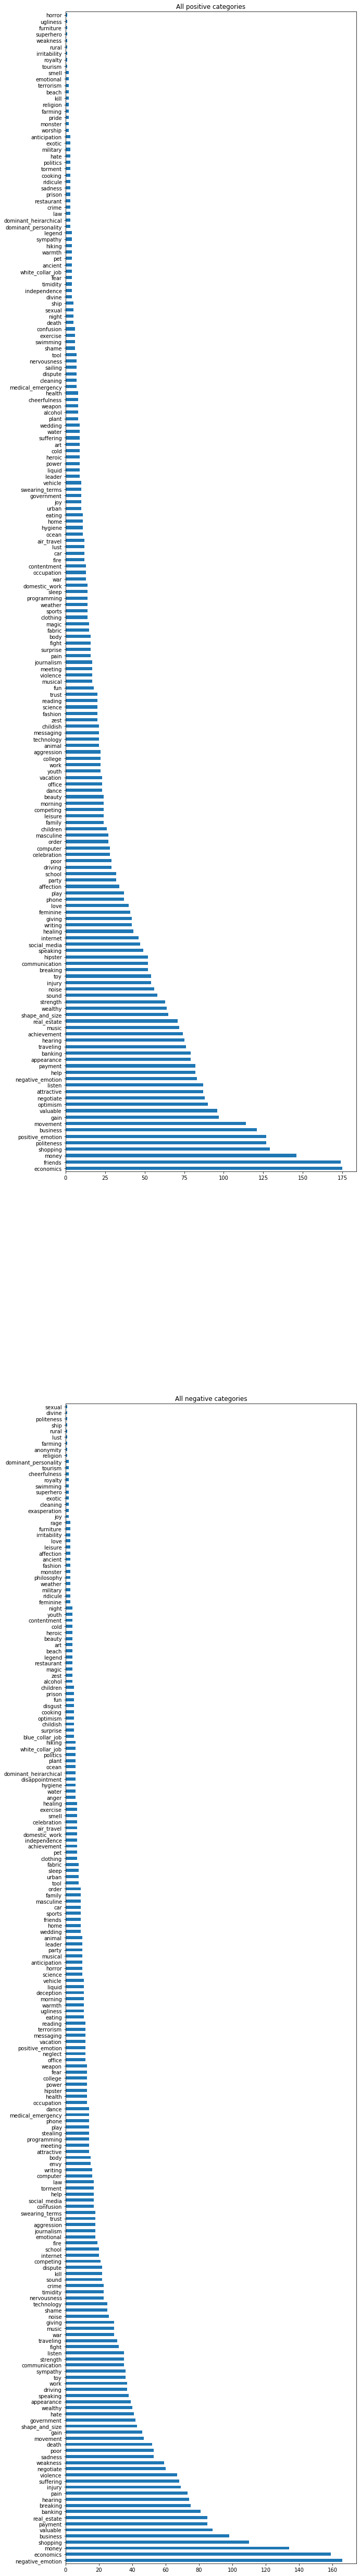

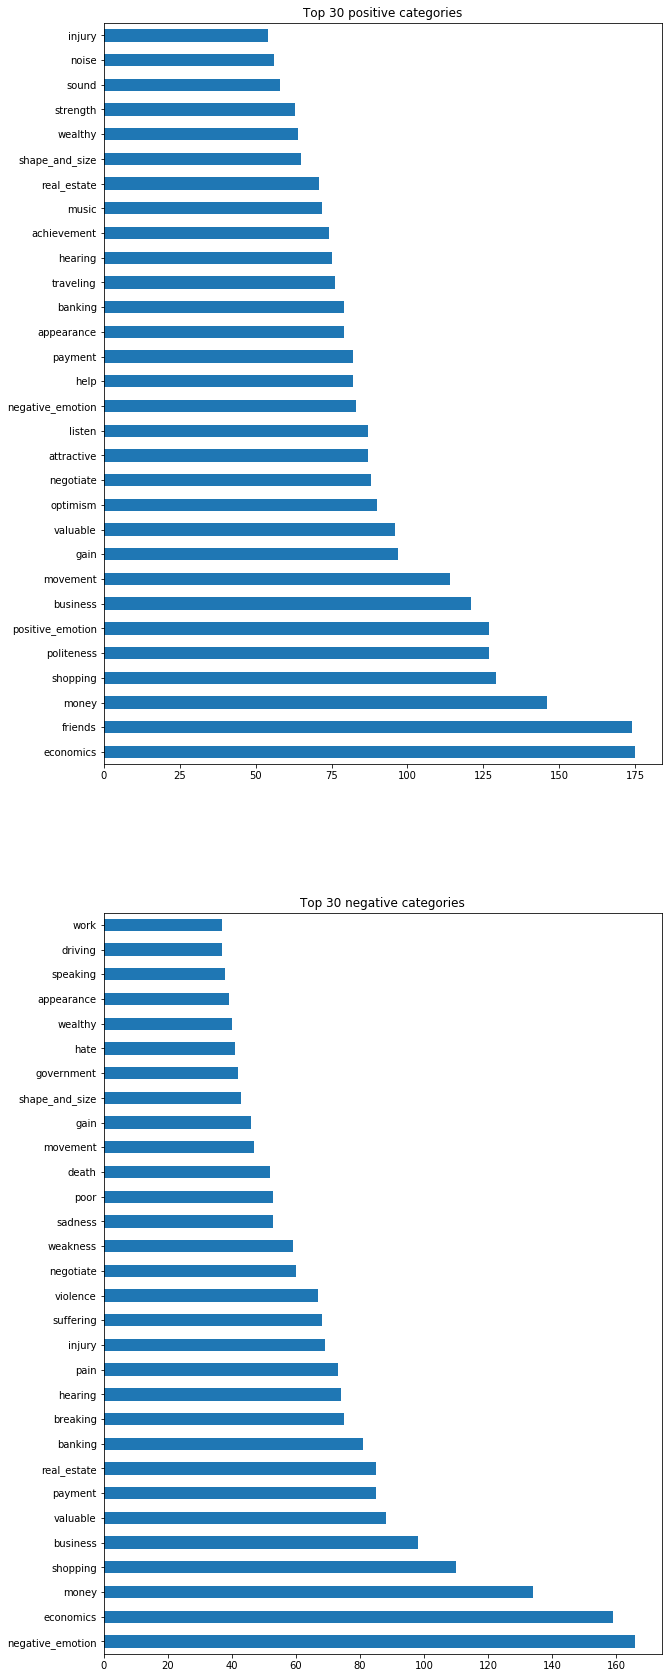

In [26]:
conn = sqlite3.connect('data.db')
c = conn.cursor()
# get the overall  SS and vader sentiment values for each text
c.execute('''SELECT sentistrength.id, sentistrength.overall, vader.overall
    FROM sentistrength
    INNER JOIN vader
    ON sentistrength.id = vader.id''')
results = c.fetchall()

# find text indexes where both sentistrength and vader have predicted the same sentiment
pos_idxs = []
neg_idxs = []
for idx, ss_sent, vader_sent in results:
    if ss_sent > 0 and vader_sent > 0:
        pos_idxs.append(idx)
    elif ss_sent < 0 and vader_sent < 0:
        neg_idxs.append(idx)

# get categories for the indexes
pos_cats = []
neg_cats = []

# indexes with positive sentiment
for idx in pos_idxs:
    c.execute(f'''SELECT empath_categories.category_name
        FROM empath_categories
        INNER JOIN empath
        ON empath_categories.category_id = empath.category_id
        WHERE empath.id = {idx}''')
    cats = c.fetchall()
    if not cats:
        continue
    for cat in cats:
        pos_cats.append(cat[0])

# indexes with negative sentiment
for idx in neg_idxs:
    c.execute(f'''SELECT empath_categories.category_name
        FROM empath_categories
        INNER JOIN empath
        ON empath_categories.category_id = empath.category_id
        WHERE empath.id = {idx}''')
    cats = c.fetchall()
    if not cats:
        continue
    for cat in cats:
        neg_cats.append(cat[0])
conn.close()

pos_df = pd.DataFrame(pos_cats, columns=["Positive_categories"])
neg_df = pd.DataFrame(neg_cats, columns=["Negative_categories"])

fig, axes = plt.subplots(nrows=2, ncols=1)
pos_df['Positive_categories'].value_counts().plot(kind='barh', figsize=(10, 90), ax=axes[0], title="All positive categories")
neg_df['Negative_categories'].value_counts().plot(kind='barh', figsize=(10, 90), ax=axes[1], title="All negative categories")
fig, axes = plt.subplots(nrows=2, ncols=1)
pos_df['Positive_categories'].value_counts()[:30].plot(kind='barh', figsize=(10, 30), ax=axes[0], title="Top 30 positive categories")
neg_df['Negative_categories'].value_counts()[:30].plot(kind='barh', figsize=(10, 30), ax=axes[1], title="Top 30 negative categories")


## 6. 
Scrutinize the categories provided by Empath, and discriminate categories that are intuitively assigned to positive sentiment and those assigned to negative sentiment. Evaluate the validity of the statement that “the presence of positive sentiment associated Empath category in the review entails a positive sentiment” and  “the presence of negative sentiment associated Empath category in the review entails a negative sentiment”.   Propose how you will validate such statements using a simple correlation analysis.  

Text(0.5, 1.0, '6. Empath, negative')

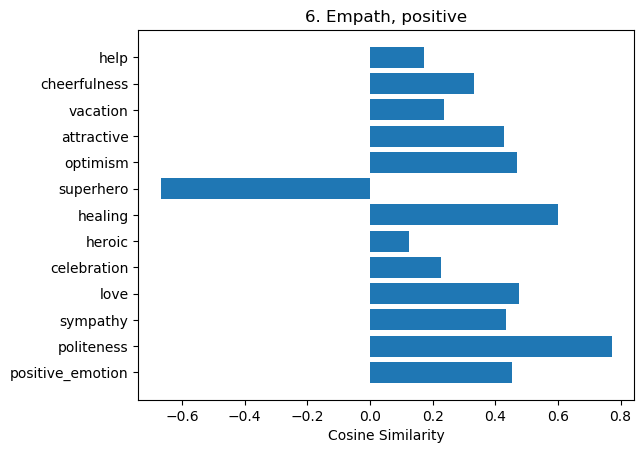

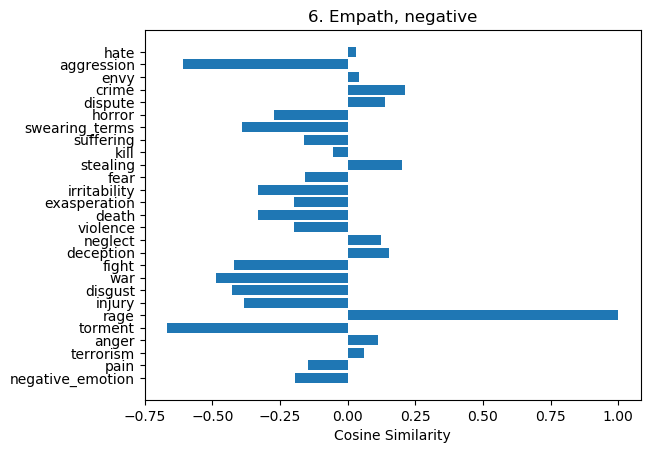

In [28]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load positive and negative empath categories
cat_pos = []
cat_neg = []

file1 = open("empath_categories_pos.txt","r") 
cat_pos = file1.readlines()
cat_pos = [cat[:-1] for cat in cat_pos]
file1.close() 

file1 = open("empath_categories_neg.txt","r") 
cat_neg = file1.readlines()
cat_neg = [cat[:-1] for cat in cat_neg]
file1.close() 

similarity_pos = []
similarity_neg = []

conn = sqlite3.connect('data.db')
c = conn.cursor()

# Positive emapath categories from tweets
positive_similarity_count = 0

for cat in cat_pos:

    c.execute(f'''SELECT category_id from empath_categories
        WHERE category_name = "{cat}"''')
    
    cat_id = c.fetchone()[0]

    c.execute(f'''SELECT id from empath
        WHERE category_id = "{cat_id}"''')
      
    tweet_ids = c.fetchall()
    
    tweet_sentiments = []
    tweet_sentiments.append([])
    tweet_amount = 0

    for tweet in tweet_ids:
        tweet = tweet[0]
        c.execute(f'''SELECT sentiment from stock_data where id = "{tweet}"''')
        tweet_sentiments[0].append(c.fetchone()[0])
        
        tweet_amount += 1 
    
    tweet_sentiments.insert(1,[1]*tweet_amount)
    similarity_pos.append(round((cosine_similarity(tweet_sentiments))[0][1],3))
   
    #if round((cosine_similarity(tweet_sentiments))[0][1],3) > 0:
        #positive_similarity_count += 1

#print("Empath positive categories, positive similarity", positive_similarity_count, "/", len(cat_pos))

# Negative categories from tweets
positive_similarity_count = 0
for cat in cat_neg:

    c.execute(f'''SELECT category_id from empath_categories
        WHERE category_name = "{cat}"''')
    
    cat_id = c.fetchone()[0]

    c.execute(f'''SELECT id from empath
        WHERE category_id = "{cat_id}"''')
      
    tweet_ids = c.fetchall()
    
    tweet_sentiments = []
    tweet_sentiments.append([])
    tweet_amount = 0
    
    for tweet in tweet_ids:
        tweet = tweet[0]
        c.execute(f'''SELECT sentiment from stock_data where id = "{tweet}"''')
        tweet_sentiments[0].append(c.fetchone()[0])
        tweet_amount += 1 
    
    tweet_sentiments.insert(1,[-1]*tweet_amount)
    similarity_neg.append(round((cosine_similarity(tweet_sentiments))[0][1],3))
    
    #print(cat, " sent:", sum(tweet_sentiments[0]), " emp:", sum(tweet_sentiments[1]), "cos",round((cosine_similarity(tweet_sentiments))[0][1],3))
    #if round((cosine_similarity(tweet_sentiments))[0][1],3) > 0:
        #positive_similarity_count += 1

#print("Empath negative categories, positive similarity:", positive_similarity_count, "/", len(cat_neg))

conn.close()

# Plotting results

plt.rcdefaults()
fig, ax = plt.subplots()
fig, bx = plt.subplots()


y_labels = cat_pos
x_data = similarity_pos
              
y_pos = np.arange(len(y_labels))

ax.barh(y_pos, x_data, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(y_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Cosine Similarity')
ax.set_title('6. Empath, positive')

y_labels = cat_neg
x_data = similarity_neg
              
y_pos = np.arange(len(y_labels))

bx.barh(y_pos, x_data, align='center')
bx.set_yticks(y_pos)
bx.set_yticklabels(y_labels)
bx.invert_yaxis()  # labels read top-to-bottom
bx.set_xlabel('Cosine Similarity')
bx.set_title('6. Empath, negative')


## 7.
We would like to repeating the preceding by using the categories provided in the Harvard General Inquirer available in http://www.wjh.harvard.edu/~inquirer/inquirerbasic.xls. Repeat the reasoning of 6) when using the categories of the General Inquirer. 

In [7]:
# Get the Harvard Inquirer words from the excel file
df_hv = pd.read_excel(io='inquirerbasic.xls')

hv_pos = []
hv_neg = []

for idx, row in df_hv.iterrows():
    if row["Positiv"] == "Positiv":
        if '#' in str(row["Entry"]):
            # There are entries such as: WORTH#1, WORTH#2
            # So we need to remove #<number> from the end
            hv_pos.append(str(row["Entry"][:-2]))
        else:
            hv_pos.append(str(row["Entry"]))
    if row["Negativ"] == "Negativ":
        if '#' in str(row["Entry"]):
            # Remove # here as well
            hv_neg.append(str(row["Entry"][:-2]))
        else:
            hv_neg.append(str(row["Entry"]))

# remove duplicates
hv_pos = list(set(hv_pos))
hv_neg = list(set(hv_neg))

# make lowercase
hv_pos = [entry.lower() for entry in hv_pos]
hv_neg = [entry.lower() for entry in hv_neg]


In [12]:
# As the Harvard Inquirer categories are already lemmatized
# we only need to stem the categories and preprocess the tweets
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk import pos_tag
WN_lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")

hv_pos = [stemmer.stem(entry) for entry in hv_pos]
hv_neg = [stemmer.stem(entry) for entry in hv_neg]


preprocessed_tweets = []
for tweet in df["Tokenized"]:

    tweet = [word.lower() for word in tweet]

    pos_tagged = pos_tag(tweet)
    tweet = []
    for word, tag in pos_tagged:
        if tag.startswith('J'):
            tag = "a"
        elif tag.startswith('N'):
            tag = "n"
        elif tag.startswith('V'):
            tag = "v"
        else:
            tweet.append(word)
            continue
        word = WN_lemmatizer.lemmatize(word, tag)    
        tweet.append(word)
  
    tweet = [stemmer.stem(word) for word in tweet]
    tweet = [word for word in tweet if word.isalpha()]

    preprocessed_tweets.append(tweet)

In [13]:
# get the positive and negative Harvard Inquirer words 
# from the tweets and add them to corresponding lists
positiv = []
negativ = []
hv_pos_found = []
hv_neg_found = []
for tweet in preprocessed_tweets:
    tweet_positiv = []
    tweet_negativ = []
    for word in tweet:
        if word in hv_pos and word not in tweet_positiv:
            tweet_positiv.append(word)
            if word not in hv_pos_found:
                hv_pos_found.append(word)
        if word in hv_neg and word not in tweet_negativ:
            tweet_negativ.append(word)
            if word not in hv_neg_found:
                hv_neg_found.append(word)
    positiv.append(tweet_positiv)
    negativ.append(tweet_negativ)

empty_counter = 0
neutral_counter = 0
for pos, neg in zip(positiv, negativ):
    if not pos and not neg:
        empty_counter += 1
    elif len(pos) == len(neg):
        neutral_counter += 1
print("Number of tweets without any HI categories", empty_counter)
print("Number of tweets where the number of positive and negative HI categories is the same:", neutral_counter)

Number of tweets without any HI categories 1082
Number of tweets where the number of positive and negative HI categories is the same: 883


In [14]:
# Create a new dataframe that has the user sentiment labels
# and all the HI categories that were found in the tweets
sent_hi_df = pd.DataFrame(df["Sentiment"], columns=["Sentiment"])
for hi_cat in hv_pos_found:
    sent_hi_df[hi_cat] = 0
for hi_cat in hv_neg_found:
    sent_hi_df[hi_cat] = 0

# Add found categories for each tweet
for idx, (pos_hi_cat, neg_hi_cat) in enumerate(zip(positiv, negativ)):
    if pos_hi_cat:
        for cat in pos_hi_cat:
               sent_hi_df.loc[idx, cat] = 1
    if neg_hi_cat:
        for cat in neg_hi_cat:
               sent_hi_df.loc[idx, cat] = -1
sent_hi_df.head()

,Sentiment,return,indic,just,like,will,correct,support,open,buy,...,absenc,grim,scheme,insuffici,rattl,refrain,avert,crumbl,deficit,peril
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Find HI categories that seem to entail positive/negative sentiment in tweets
from sklearn.metrics.pairwise import cosine_similarity
best_hi_pos_cats = []
best_hi_neg_cats = []
cols = sent_hi_df.columns

for col in cols[1:]:
    sents = sent_hi_df.loc[sent_hi_df[col] != 0][["Sentiment", col]]
    c = cosine_similarity([list(sents["Sentiment"])], [list(sents[col])])[0][0]
    if c > 0.0:
        if list(sents[col])[0] == 1:
            best_hi_pos_cats.append(col)
        else:
            best_hi_neg_cats.append(col)

            

print("Total number of categories:", len(cols[1:]))
print("Number of positive categories entailing positive sentiment", len(best_hi_pos_cats))
print("Number of negative categories entailing negative sentiment", len(best_hi_neg_cats))


Total number of categories: 900
Number of positive categories entailing positive sentiment 280
Number of negative categories entailing negative sentiment 204


## 8.
Construct a simple ontology that describes “gain” and “loss” on business field. For instance, you can start by generating all wording that may refer to “gain”, e.g., increase, high, additional, extra, benefit, shares, … And do the same for “loss”. Describe your own heuristic for generating these wording, you can consult either generic lexical database such as WordNet or specialized business oriented ontology.   



In [16]:
# words gathered in text files
with open('gain.txt', 'r') as gf:
    gain_words = gf.readlines()
    gain_words = [gain_word[:-1] for gain_word in gain_words]
    
    
with open('loss.txt', 'r') as lf:
    loss_words = lf.readlines()
    loss_words = [loss_word[:-1] for loss_word in loss_words]
    
print(gain_words)
print(loss_words)


['increase', 'high', 'additional', 'extra', 'benefit', 'shares', 'profit', 'acquire', 'win', 'attain', 'advance', 'gather', 'earnings', 'stash', 'bank', 'advance', 'earn', 'bring in', 'take in', 'make', 'increment', 'stock', 'growth', 'improve', 'promotion', 'rise', 'commission', 'lucrative', 'ascent']
['decrease', 'low', 'depreciation', 'lose', 'depression', 'depleted', 'down', 'penalty', 'debt', 'deficit', 'disadvantage', 'fall', 'reduce', 'diminish', 'lessen', 'shrink', 'diminution', 'plummet', 'dive', 'scarcity', 'descent']


In [17]:
# preprocess ontology, as they are in root form, only stemming is needed
# so that it matches better with the processed tweets

stemmer = SnowballStemmer("english")
print(gain_words)
print(loss_words)
print("\n")

prepr_gws = [stemmer.stem(gw) for gw in gain_words]
prepr_lws = [stemmer.stem(lw) for lw in loss_words]
print(prepr_gws)
print(prepr_lws)
print("\n")


['increase', 'high', 'additional', 'extra', 'benefit', 'shares', 'profit', 'acquire', 'win', 'attain', 'advance', 'gather', 'earnings', 'stash', 'bank', 'advance', 'earn', 'bring in', 'take in', 'make', 'increment', 'stock', 'growth', 'improve', 'promotion', 'rise', 'commission', 'lucrative', 'ascent']
['decrease', 'low', 'depreciation', 'lose', 'depression', 'depleted', 'down', 'penalty', 'debt', 'deficit', 'disadvantage', 'fall', 'reduce', 'diminish', 'lessen', 'shrink', 'diminution', 'plummet', 'dive', 'scarcity', 'descent']


['increas', 'high', 'addit', 'extra', 'benefit', 'share', 'profit', 'acquir', 'win', 'attain', 'advanc', 'gather', 'earn', 'stash', 'bank', 'advanc', 'earn', 'bring in', 'take in', 'make', 'increment', 'stock', 'growth', 'improv', 'promot', 'rise', 'commiss', 'lucrat', 'ascent']
['decreas', 'low', 'depreci', 'lose', 'depress', 'deplet', 'down', 'penalti', 'debt', 'deficit', 'disadvantag', 'fall', 'reduc', 'diminish', 'lessen', 'shrink', 'diminut', 'plummet', '

## 9.
We would like to repeat 7) by looking whether the presence of “gain” associated tweets would entail positive sentiment and that of “loss” related tweets entail negative sentiment. Suggest your own heuristic how you will achieve this. You determine the proportion of the tweets containing “gain” related terms and assigned to positive sentiment over the total number of tweets containing “gain” related terms, and repeat similar reasoning for “loss” related tweets. 

In [18]:
# Get tweets with gain/loss related wordings 
tweet_gain_words = []
tweet_loss_words = []
gain_found = []
loss_found = []
for tweet in preprocessed_tweets:
    tweet_gain = []
    tweet_loss = []
    for word in tweet:
        if word in prepr_gws and word not in tweet_gain:
            tweet_gain.append(word)
            if word not in gain_found:
                gain_found.append(word)
        if word in prepr_lws and word not in tweet_loss:
            tweet_loss.append(word)
            if word not in loss_found:
                loss_found.append(word)
    tweet_gain_words.append(tweet_gain)
    tweet_loss_words.append(tweet_loss)

empty_counter = 0
neutral_counter = 0
for pos, neg in zip(tweet_gain_words, tweet_loss_words):
    if not pos and not neg:
        empty_counter += 1
    elif len(pos) == len(neg):
        neutral_counter += 1
print(gain_found)
print(loss_found)
print("Number of tweets without gain/loss related words",empty_counter)
print("Number of tweets where the number of gain/loss related words is the same:", neutral_counter)

['win', 'high', 'share', 'stock', 'make', 'earn', 'profit', 'addit', 'increas', 'improv', 'acquir', 'rise', 'advanc', 'bank', 'growth', 'benefit', 'promot', 'commiss', 'gather']
['low', 'down', 'lose', 'debt', 'reduc', 'fall', 'decreas', 'dive', 'depress', 'plummet', 'shrink', 'deficit']
Number of tweets without gain/loss related words 4090
Number of tweets where the number of gain/loss related words is the same: 101


In [19]:
# add gain/loss related words to a df
gainloss_df = pd.DataFrame(df["Sentiment"], columns=["Sentiment"])
gainloss_df["GainRelated"] = 0
gainloss_df["LossRelated"] = 0
for gain_word in gain_found:
    gainloss_df[gain_word] = 0
for loss_word in loss_found:
    gainloss_df[loss_word] = 0

# Add found categories for each tweet
for idx, (gain_words, loss_words) in enumerate(zip(tweet_gain_words, tweet_loss_words)):
    if gain_words:
        gainloss_df.loc[idx, "GainRelated"] = 1
        for word in gain_words:
            gainloss_df.loc[idx, word] = 1
    if loss_words:
        gainloss_df.loc[idx, "LossRelated"] = 1
        for word in loss_words:
            gainloss_df.loc[idx, word] = -1
gainloss_df.head()

,Sentiment,GainRelated,LossRelated,win,high,share,stock,make,earn,profit,...,lose,debt,reduc,fall,decreas,dive,depress,plummet,shrink,deficit
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Find the gain/loss related words entailing positive/negative sentiment in tweets
best_gain_words = []
best_loss_words = []
cols = gainloss_df.columns

for col in cols[1:]:
    sents = gainloss_df.loc[gainloss_df[col] != 0][["Sentiment", col]]
    c = cosine_similarity([list(sents["Sentiment"])], [list(sents[col])])[0][0]
    if c > 0.0:
        if list(sents[col])[0] == 1:
            best_gain_words.append(col)
        else:
            best_loss_words.append(col)

print("Total number of gain/loss words:", len(cols[1:]))
print(f"Number of gain words entailing positive sentiment {len(best_gain_words)}/{len(gain_found)}")
print(f"Number of loss words entailing negative sentiment {len(best_loss_words)}/{len(loss_found)}")


Total number of gain/loss words: 33
Number of gain words entailing positive sentiment 16/19
Number of loss words entailing negative sentiment 11/12


In [21]:
# Calculate the ratios:
# 1. gain related tweets with positive sentiment/all gain related tweets
# 2. loss related tweets with negative sentiment/all loss related tweets

num_pos_gain_tweets = gainloss_df.loc[(gainloss_df["GainRelated"] == 1) & (gainloss_df["Sentiment"] == 1)]
num_gain_tweets = gainloss_df.loc[(gainloss_df["GainRelated"] == 1)]
print("Gain related with positive sentiment", len(num_pos_gain_tweets))
print("All gain related tweets:", len(num_gain_tweets))
print("Ratio:", len(num_pos_gain_tweets)/len(num_gain_tweets), "\n")

num_neg_loss_tweets = gainloss_df.loc[(gainloss_df["LossRelated"] == 1) & (gainloss_df["Sentiment"] == -1)]
num_loss_tweets = gainloss_df.loc[(gainloss_df["LossRelated"] == 1)]
print("Loss related with negative sentiment", len(num_neg_loss_tweets))
print("All loss related tweets:", len(num_loss_tweets))
print("Ratio:", len(num_neg_loss_tweets)/len(num_loss_tweets))

Gain related with positive sentiment 893
All gain related tweets: 1299
Ratio: 0.6874518860662048 

Loss related with negative sentiment 353
All loss related tweets: 534
Ratio: 0.6610486891385767


## 10. 
We would like to devise a classifier that output the sentiment polarity. For this purpose, test various scenarios for building the classifier. You can perform preprocessing to eliminate noisy terms but excluding the negation. Next, you compare several realizations of the feature set: i) CountVectorizer,  ii) TF-IDF, iii) [number of positive wording of General Inquirer – Number of negative wording of General Inquirer -  Number of positive emoticons Number of negative emoticons  - length_of message]. 

In [52]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk

In [53]:
# CountVectorizer and TF-IDF
nltk.download('stopwords')
nltk.download('wordnet')
nltk_stopwords = list(set(nltk.corpus.stopwords.words('english')))

# we want to include negated words and also a few other
# words that could have meaning in this context e.g. 'up', 'down'
with open('stopwords_to_ignore.txt') as f:
    sw_to_ignore = [w[:-1] for w in f.readlines()]

stopwords = []

for nltk_sw in nltk_stopwords:
    if nltk_sw not in sw_to_ignore:
        stopwords.append(nltk_sw)
print("Stopwords: ", ", ".join(stopwords))

Stopwords:  on, out, it's, are, d, you've, them, him, than, and, hers, you, their, these, which, herself, but, t, theirs, myself, there, m, they, did, ma, its, after, further, ours, who, above, for, me, yourselves, were, re, each, just, or, yourself, some, so, few, y, i, over, into, why, where, while, o, in, that, she, having, by, against, he, how, too, can, to, have, you'd, is, you'll, our, themselves, again, here, an, during, that'll, been, being, very, should've, had, the, a, should, between, what, until, s, through, has, doing, be, this, you're, if, whom, then, once, her, both, it, my, itself, at, of, off, from, will, all, was, other, any, those, when, ve, ourselves, only, same, as, ll, such, his, do, about, we, your, am, she's, now, most, yours, does, before, himself, because, with


[nltk_data] Downloading package stopwords to /home/arttu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/arttu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [54]:
def preprocess_tokenized_tweets(tk_tweets, stopwords):
    """Remove stopwords and numbers, lemmatize and stem the words"""
    stemmer = SnowballStemmer("english")
    WN_lemmatizer = WordNetLemmatizer()
    preprocessed_tweets = []
    tokens = []
    for tweet in tk_tweets:
        tweet = [stemmer.stem(word) for word in tweet]
        tweet = [WN_lemmatizer.lemmatize(word, pos="v") for word in tweet]
        tweet = [word for word in tweet if word.isalpha() and word not in stopwords]
        preprocessed_tweets.append(" ".join(tweet))
        tokens.extend(tweet)
        
    return preprocessed_tweets, tokens

In [56]:
def preprocess_tokenized_tweets2(tk_tweets, stopwords):
    """Remove stopwords and numbers, lemmatize and stem the words"""
    stemmer = SnowballStemmer("english")
    WN_lemmatizer = WordNetLemmatizer()
    preprocessed_tweets = []
    tokens = []
    for tweet in tk_tweets:
        pos_tagged = nltk.pos_tag(tweet)
        tweet = []
        for word, tag in pos_tagged:
            if tag.startswith('J'):
                tag = "a"
            elif tag.startswith('N'):
                tag = "n"
            elif tag.startswith('V'):
                tag = "v"
            else:
                tweet.append(word)
                continue
            word = WN_lemmatizer.lemmatize(word, tag)
            tweet.append(word)
        tweet = [stemmer.stem(word) for word in tweet]
        tweet = [word for word in tweet if word.isalpha() and word not in stopwords]
        preprocessed_tweets.append(" ".join(tweet))
        tokens.extend(tweet)
        
    return preprocessed_tweets, tokens

In [118]:
def train_and_test_model(vectorizer, tokens, preprocessed_tweets, Y):
    # Fit vectorizer to encode the tweets
    vectorizer.fit(tokens)

    # Construct list of vectors X containing encoded tweets
    X = vectorizer.transform(preprocessed_tweets)

    # Divide data into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

    # Initialize and train classifier
    classifier = RandomForestClassifier(n_estimators=200, random_state=0)
    classifier.fit(X_train, Y_train)
    
    Y_pred = classifier.predict(X_test)

    # Print performance metrics
    print(confusion_matrix(Y_test, Y_pred))
    print(classification_report(Y_test, Y_pred))
    print("Accuracy: ", round(accuracy_score(Y_test, Y_pred), 3))

In [58]:
# Custom feature [num_pos_HI_cats, num_neg_HI_cats, 
# num_pos_emoticons, num_neg_emoticons, tweet_length]
# by using 1. all HI categories, 2. best performing HI categories found in Task 7

# Add num of each HI category in to the dataframe
def get_num_hi_categories(hi_df, categories):
    num_categories = []
    for idx, row in hi_df.iterrows():
        num_cats = 0
        for cat in categories:
            if hi_df.loc[idx, cat] != 0:
                num_cats += 1
        num_categories.append(num_cats)
    return num_categories


df["AllPosHI"] = get_num_hi_categories(sent_hi_df, hv_pos_found)
df["AllNegHI"] = get_num_hi_categories(sent_hi_df, hv_neg_found)
df["BestPosHI"] = get_num_hi_categories(sent_hi_df, best_hi_pos_cats)
df["BestNegHI"] = get_num_hi_categories(sent_hi_df, best_hi_pos_cats)
print(df.head())

                                                Text  Sentiment  \
0  Kickers on my watchlist XIDE TIT SOQ PNK CPW B...          1   
1  user: AAP MOVIE. 55% return for the FEA/GEED i...          1   
2  user I'd be afraid to short AMZN - they are lo...          1   
3                                  MNTA Over 12.00            1   
4                                   OI  Over 21.37            1   

                                           Tokenized  SSPos  SSNeg  SSOvrl  \
0  [Kickers, on, my, watchlist, XIDE, TIT, SOQ, P...    0.0    1.0    -1.0   
1  [user, :, AAP, MOVIE, ., 55, %, return, for, t...    1.0    0.0     2.0   
2  [user, I'd, be, afraid, to, short, AMZN, -, th...    1.0    1.0    -2.0   
3                                [MNTA, Over, 12.00]    0.0    0.0     0.0   
4                                  [OI, Over, 21.37]    0.0    0.0     0.0   

   VaderPos  VaderNeg  VaderOvrl  SSBin  SSPosNeuNeg  VaderBin  \
0       0.0       0.0        0.0    0.0         -1.0       1.0

In [59]:
# Get the emoticons for the custom feature
with open ('positive_emoticons.txt', 'r') as f:
    pos_emoticons = f.readlines()
    pos_emoticons = [emoticon[:-1] for emoticon in pos_emoticons]
with open ('negative_emoticons.txt', 'r') as f:
    neg_emoticons = f.readlines()
    neg_emoticons = [emoticon[:-1] for emoticon in neg_emoticons]

# find positive and negative emoticons from the tweets
found_pos_emoticons = []
found_neg_emoticons = []
# keep track how many actually have the opposing sentiment
wrong_counter = [0, 0]

# initialize dataframe columns
df["NumPosEmoticons"] = 0
df["NumNegEmoticons"] = 0
for idx, row in df.iterrows():
    tweet = row["Tokenized"]
    for t in tweet:
        num_pos_emo = 0
        num_neg_emo = 0
        if t in pos_emoticons:
            found_pos_emoticons.append(t)
            num_pos_emo += 1
            if row["Sentiment"] == -1:
                wrong_counter[0] += 1
        elif t in neg_emoticons:
            found_neg_emoticons.append(t)
            num_neg_emo += 1
            if row["Sentiment"] == 1:
                wrong_counter[1] += 1
    df.loc[idx, "NumPosEmoticons"] = num_pos_emo
    df.loc[idx, "NumNegEmoticons"] = num_neg_emo
    
# as there are only 93 emoticons in the almost 6000 tweets
# it does not really make sense to use it as a feature
print("Wrong counter (pos/neg): ", wrong_counter)
print("Number of positive emoticons: ", len(found_pos_emoticons))
print("Number of negative emoticons: ",len(found_neg_emoticons))

Wrong counter (pos/neg):  [18, 8]
Number of positive emoticons:  81
Number of negative emoticons:  12


In [60]:
# Lastly we need to get the number of words in a tweet
# we could do either: number of words in original tweet or in tokenized
# so let's do both to see if it has any effect

df["TweetLengthFull"] = 0
df["TweetLengthTokens"] = 0
for idx, row in df.iterrows():
    full_len = len(row["Text"].split(" "))
    tokens_len = len(row["Tokenized"])
    df.loc[idx, "TweetLengthFull"] = full_len
    df.loc[idx, "TweetLengthTokens"] = tokens_len

In [61]:
# Check what the feature looks like
print(df[["AllPosHI", "AllNegHI", "NumPosEmoticons", "NumNegEmoticons", "TweetLengthFull"]])

# It looks like there are many rows that have nonzero values only in tweet length
print("Number of features where all but tweetlength is 0:",
      len(df.loc[(df["AllPosHI"] == 0) & (df["AllNegHI"] == 0)
    & (df["NumPosEmoticons"] == 0) & (df["NumNegEmoticons"] == 0)]))


      AllPosHI  AllNegHI  NumPosEmoticons  NumNegEmoticons  TweetLengthFull
0            0         0                0                0               21
1            3         0                0                0               19
2            1         2                0                0               18
3            0         0                0                0                5
4            0         0                0                0                6
...        ...       ...              ...              ...              ...
5786         2         2                0                0               18
5787         1         1                0                0               15
5788         0         1                0                0               24
5789         2         1                0                0               17
5790         0         1                0                0               16

[5791 rows x 5 columns]
Number of features where all but tweetlength is 0: 1072


In [69]:
# Another, most likely better performing custom feature
print(df[["AllPosHI", "AllNegHI", "NumPosEmoticons", "NumNegEmoticons", "TweetLengthFull", "SSPosNeuNeg"]])

      AllPosHI  AllNegHI  NumPosEmoticons  NumNegEmoticons  TweetLengthFull  \
0            0         0                0                0               21   
1            3         0                0                0               19   
2            1         2                0                0               18   
3            0         0                0                0                5   
4            0         0                0                0                6   
...        ...       ...              ...              ...              ...   
5786         2         2                0                0               18   
5787         1         1                0                0               15   
5788         0         1                0                0               24   
5789         2         1                0                0               17   
5790         0         1                0                0               16   

      SSPosNeuNeg  
0            -1.0  
1          

## 11.
Use a 70% training, 30% testing, split of the original dataset and a random forest algorithm as a classifier to perform this classification. Compare the result in terms of accuracy for each version of this classifier (when taking into account the various features). 

In [62]:
# modified stopwords 
preprocessed_tweets, tokens = preprocess_tokenized_tweets2(df["Tokenized"], stopwords)
print("Count Vectorizer-------------------------------------")
train_and_test_model(CountVectorizer(), tokens, preprocessed_tweets, list(df["Sentiment"]))
print("\nTfidf Vectorizer-------------------------------------")
train_and_test_model(TfidfVectorizer(), tokens, preprocessed_tweets, list(df["Sentiment"]))

Count Vectorizer-------------------------------------
[[405 220]
 [166 947]]
              precision    recall  f1-score   support

          -1       0.71      0.65      0.68       625
           1       0.81      0.85      0.83      1113

    accuracy                           0.78      1738
   macro avg       0.76      0.75      0.75      1738
weighted avg       0.77      0.78      0.78      1738

Accuracy:  0.778

Tfidf Vectorizer-------------------------------------
[[363 262]
 [114 999]]
              precision    recall  f1-score   support

          -1       0.76      0.58      0.66       625
           1       0.79      0.90      0.84      1113

    accuracy                           0.78      1738
   macro avg       0.78      0.74      0.75      1738
weighted avg       0.78      0.78      0.78      1738

Accuracy:  0.784


In [63]:
# defaul nltk stopwords
preprocessed_tweets, tokens = preprocess_tokenized_tweets2(df["Tokenized"], nltk_stopwords)
print("Count Vectorizer-------------------------------------")
train_and_test_model(CountVectorizer(), tokens, preprocessed_tweets, list(df["Sentiment"]))
print("\nTfidf Vectorizer-------------------------------------")
train_and_test_model(TfidfVectorizer(), tokens, preprocessed_tweets, list(df["Sentiment"]))

Count Vectorizer-------------------------------------
[[394 231]
 [163 950]]
              precision    recall  f1-score   support

          -1       0.71      0.63      0.67       625
           1       0.80      0.85      0.83      1113

    accuracy                           0.77      1738
   macro avg       0.76      0.74      0.75      1738
weighted avg       0.77      0.77      0.77      1738

Accuracy:  0.773

Tfidf Vectorizer-------------------------------------
[[ 356  269]
 [ 102 1011]]
              precision    recall  f1-score   support

          -1       0.78      0.57      0.66       625
           1       0.79      0.91      0.84      1113

    accuracy                           0.79      1738
   macro avg       0.78      0.74      0.75      1738
weighted avg       0.79      0.79      0.78      1738

Accuracy:  0.787


In [119]:
# no stopwords
preprocessed_tweets, tokens = preprocess_tokenized_tweets2(df["Tokenized"], [])
print("Count Vectorizer-------------------------------------")
train_and_test_model(CountVectorizer(), tokens, preprocessed_tweets, list(df["Sentiment"]))
print("\nTfidf Vectorizer-------------------------------------")
train_and_test_model(TfidfVectorizer(), tokens, preprocessed_tweets, list(df["Sentiment"]))

Count Vectorizer-------------------------------------
[[375 250]
 [121 992]]
              precision    recall  f1-score   support

          -1       0.76      0.60      0.67       625
           1       0.80      0.89      0.84      1113

    accuracy                           0.79      1738
   macro avg       0.78      0.75      0.76      1738
weighted avg       0.78      0.79      0.78      1738

Accuracy:  0.787

Tfidf Vectorizer-------------------------------------
[[ 348  277]
 [  93 1020]]
              precision    recall  f1-score   support

          -1       0.79      0.56      0.65       625
           1       0.79      0.92      0.85      1113

    accuracy                           0.79      1738
   macro avg       0.79      0.74      0.75      1738
weighted avg       0.79      0.79      0.78      1738

Accuracy:  0.787


In [206]:
def train_and_test_hi_model(X, Y, print_report=True):
    # Divide data into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

    # Initialize and train classifier
    classifier = RandomForestClassifier(n_estimators=500, random_state=0)
    classifier.fit(X_train, Y_train)
    
    Y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    # Print performance metrics
    if print_report:
        print(confusion_matrix(Y_test, Y_pred))
        print(classification_report(Y_test, Y_pred))
        print("Accuracy: ", accuracy)
    return accuracy

In [66]:
# All HI categories and full tweet length
features = df[
    ["AllPosHI", "AllNegHI", 
     "NumPosEmoticons", "NumNegEmoticons", 
     "TweetLengthFull"]].values.tolist()
train_and_test_hi_model(features, list(df["Sentiment"]))

5791
5791
[[212 413]
 [190 923]]
              precision    recall  f1-score   support

          -1       0.53      0.34      0.41       625
           1       0.69      0.83      0.75      1113

    accuracy                           0.65      1738
   macro avg       0.61      0.58      0.58      1738
weighted avg       0.63      0.65      0.63      1738

Accuracy:  0.6530494821634062


In [67]:
# All HI categories and tokenized tweet length
features = df[
    ["AllPosHI", "AllNegHI", 
     "NumPosEmoticons", "NumNegEmoticons", 
     "TweetLengthTokens"]].values.tolist()
train_and_test_hi_model(features, list(df["Sentiment"]))

5791
5791
[[223 402]
 [216 897]]
              precision    recall  f1-score   support

          -1       0.51      0.36      0.42       625
           1       0.69      0.81      0.74      1113

    accuracy                           0.64      1738
   macro avg       0.60      0.58      0.58      1738
weighted avg       0.62      0.64      0.63      1738

Accuracy:  0.6444188722669736


In [68]:
# Best HI categories and tokenized tweet length
features = df[
    ["BestPosHI", "BestNegHI", 
     "NumPosEmoticons", "NumNegEmoticons", 
     "TweetLengthTokens"]].values.tolist()
train_and_test_hi_model(features, list(df["Sentiment"]))

5791
5791
[[ 111  514]
 [ 110 1003]]
              precision    recall  f1-score   support

          -1       0.50      0.18      0.26       625
           1       0.66      0.90      0.76      1113

    accuracy                           0.64      1738
   macro avg       0.58      0.54      0.51      1738
weighted avg       0.60      0.64      0.58      1738

Accuracy:  0.6409666283084005


Findings:
Accuracies:

0.778 CountVectorizer, custom stopwords

0.784 TF-IDF, custom stopwords

0.773 CountVectorizer, nltk stopwords

0.787 TF-IDF, nltk stopwords

0.787 CountVectorizer, no stopwords

0.787 TF-IDF, no stopwords

0.638-0.656 Custom features (HI_pos, HI_neg, pos_emoticon, neg_emoticon, tweetlength)

In [175]:
feature_cols = [
     "BestPosHI", 
     "BestNegHI", 
     "NumPosEmoticons", 
     "NumNegEmoticons", 
     "TweetLengthTokens",
     "TweetLengthFull",
     "SSBin",
     "VaderBin",
     "SSPosNeuNeg",
     "VaderPosNeuNeg",
     "GainRelated",
     "LossRelated",
    ]
feature_cols = np.array(feature_cols)
df["GainRelated"] = gainloss_df["GainRelated"]
df["LossRelated"] = gainloss_df["LossRelated"]



combinations = pow(2 ,len(feature_cols))
accuracy_list = []
for i in range(combinations):
    idx = i + 1
    print(idx)
    binary_i = (format(idx,'012b'))
    arr = np.array(list(binary_i))
    bin_mask = arr == '1'
    chosen = feature_cols[bin_mask]
    features = df[chosen].values.tolist()
    acc = train_and_test_hi_model(features, list(df["Sentiment"]), print_report=False)
    chosen_str = ' '.join(chosen)
    accuracy_list.append((acc, chosen_str))


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699


IndexError: boolean index did not match indexed array along dimension 0; dimension is 12 but corresponding boolean dimension is 13

In [205]:
# The above error is no problemo .. took quite a while to run so no re-running
# A sneak peek suggested the max accuracy was 0.689, let's see what features were used
acc_list = sorted(accuracy_list, key=lambda t: t[0], reverse=True)
feature_counter = Counter()
number_of_combinations = 0
print("Best performing\nAccuracy, number of features, features")
for acc, features in acc_list[:40]:
    feature_arr = features.split(' ')
    print(round(acc, 3), len(feature_arr), features)
    if acc < 0.68:
        break
    number_of_combinations += 1
    for f in feature_arr:
        feature_counter[f] += 1

best_features = []
print("\nNumber of feature combinations with 68% accuracy:", number_of_combinations)
for f in feature_counter:
    best_features.append(f)
    feature_arr = f
    print(f, feature_counter[f])

print("\nFeatures that were not in the highest performing models:")
for feature in feature_cols:
    if feature not in best_features:
        print(feature)
        
# why not to check the top 10 worst features as we are here
print("\nWorst 10 feature combinations")
for i in range(len(acc_list)):
    if i == 10:
        break
    idx = -i - 1
    acc, features = acc_list[idx]
    print(acc, features)
    

Best performing
Accuracy, number of features, features
0.689 6 BestNegHI NumPosEmoticons NumNegEmoticons SSBin GainRelated LossRelated
0.689 6 BestPosHI NumPosEmoticons NumNegEmoticons SSBin GainRelated LossRelated
0.689 7 BestNegHI NumPosEmoticons SSBin VaderBin SSPosNeuNeg GainRelated LossRelated
0.689 6 BestNegHI NumPosEmoticons NumNegEmoticons SSPosNeuNeg GainRelated LossRelated
0.689 7 BestNegHI NumPosEmoticons NumNegEmoticons VaderBin SSPosNeuNeg GainRelated LossRelated
0.689 7 BestNegHI NumPosEmoticons NumNegEmoticons SSBin SSPosNeuNeg GainRelated LossRelated
0.689 8 BestNegHI NumPosEmoticons NumNegEmoticons SSBin SSPosNeuNeg VaderPosNeuNeg GainRelated LossRelated
0.689 7 BestPosHI NumPosEmoticons SSBin VaderBin SSPosNeuNeg GainRelated LossRelated
0.689 6 BestPosHI NumPosEmoticons NumNegEmoticons SSPosNeuNeg GainRelated LossRelated
0.689 7 BestPosHI NumPosEmoticons NumNegEmoticons VaderBin SSPosNeuNeg GainRelated LossRelated
0.689 7 BestPosHI NumPosEmoticons NumNegEmoticons SSBi

It is safe to say that:

-Tweet length is not a good feature

-SSPosNeuNeg seems to be the best feature out of the SentiStrength/Vader analysis results

    -Could be interesting to see if the total sentiment was taken into account instead of 1, 0, -1
    
-Before we got to 65.3% accuracy with 5 features, now we got 68.8% accuracy with a few different combinations of features
    
It is rather surprising that:

-Both of the emoticon features are often among the top performing features

-VaderPosNeuNeg is only 3 times in the top performing features even though earlier we concluded that Vader and SentiStrenght provide rather similar results (pearson correlation around 0.7)

-BestNegHI and BestPosHI don't coexist in the best performing features that often

It is rather dissapointing to see that:

-AllPosHI and AllNegHI features were not included in the test, as they outperfomed BestPosHI and BestNegHI features in the earlier tests.. let's pick some of the best performing features and see if changing from BestHI to AllHI improves performance

    -The testing below showed that using AllHI wordings reduced the accuracy slightly

In [211]:
# Testing with a couple of custom features where BestPos/NegHI is switched to ALLPos/Neg/HI
# Before: 0.689 6 BestNegHI NumPosEmoticons NumNegEmoticons SSBin GainRelated LossRelated
print("AllNegHI NumPosEmoticons, NumNegEmoticons SSBin GainRelated LossRelated")
features = df[
    ["AllNegHI", "NumPosEmoticons", "NumNegEmoticons", "SSBin", "GainRelated", "LossRelated"]].values.tolist()
train_and_test_hi_model(features, list(df["Sentiment"]))

# 0.689 6 BestPosHI NumPosEmoticons NumNegEmoticons SSBin GainRelated LossRelated
print("\nAllPosHI NumPosEmoticons NumNegEmoticons SSBin GainRelated LossRelated")
features = df[
    ["AllPosHI", "NumPosEmoticons", "NumNegEmoticons", "SSBin", "GainRelated", "LossRelated"]].values.tolist()
train_and_test_hi_model(features, list(df["Sentiment"]))

# 0.688 5 BestNegHI NumNegEmoticons SSBin GainRelated LossRelated
print("\nAllNegHI NumNegEmoticons SSBin GainRelated LossRelated")
features = df[
    ["AllNegHI", "NumNegEmoticons", "SSBin", "GainRelated", "LossRelated"]].values.tolist()
train_and_test_hi_model(features, list(df["Sentiment"]))


AllNegHI NumPosEmoticons, NumNegEmoticons SSBin GainRelated LossRelated
[[214 411]
 [152 961]]
              precision    recall  f1-score   support

          -1       0.58      0.34      0.43       625
           1       0.70      0.86      0.77      1113

    accuracy                           0.68      1738
   macro avg       0.64      0.60      0.60      1738
weighted avg       0.66      0.68      0.65      1738

Accuracy:  0.6760644418872267

AllPosHI NumPosEmoticons NumNegEmoticons SSBin GainRelated LossRelated
[[217 408]
 [138 975]]
              precision    recall  f1-score   support

          -1       0.61      0.35      0.44       625
           1       0.70      0.88      0.78      1113

    accuracy                           0.69      1738
   macro avg       0.66      0.61      0.61      1738
weighted avg       0.67      0.69      0.66      1738

Accuracy:  0.6858457997698504

AllNegHI NumNegEmoticons SSBin GainRelated LossRelated
[[216 409]
 [155 958]]
              pre

0.6754890678941312